# License Plate Detection

In [1]:
# installing missing YOLO dependencies
%pip install lapx>=0.5.2
# installing OCR library
%pip install easyocr
#installing CNN model
%pip install tensorflow

%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We are importing the following libraries:
* **ast** for parsing the bounding boxes
* **cv2** for video processing
* **easyocr** for OCR
* **glob** for finding files
* **numpy** for array operations
* **pandas** for dataframes
* **string** for string operations
* **ultralytics** for **YOLO** for object detection

In [2]:
import ast
import cv2 as cv
import easyocr
from glob import glob
import numpy as np
import pandas as pd
import string
from ultralytics import YOLO
from keras.models import load_model

## License Plate Detection

**YOLOv8** is capable of detecting cars, buses and trucks very easily without additional trainings from the dataset.It is already trained from the COCO dataset.But license number plates seem to be a bit harder. The model often confuses street signs or just basic backgound noise as a car registration plate. 
<br/>
<br/>
To make things more efficient, we are combining both models - a regular COCO trained YOLOv8 and our number plate detector.If the COCO model spots a car, we will then execute the number plate detector to focus its search within the area marked out by the first model's bounding box. That way, we are only seaarching for number plates when there is a car in the picture.

This is a regular COCO trained YOLOv8 model for car detection.<br/>
`coco_model = YOLO('yolov8n.pt')`

This is our custom model trained on the License Plate Dataset.<br/>
`np_model = YOLO('../model/runs/detect/train/weights/best.pt')`

*best.pt* weight is produced by training our model with +21000 annoted images of license plates for 3 epochs.

In [107]:
coco_model = YOLO('yolov8n.pt')
np_model = YOLO('../model/runs/detect/train/weights/best.pt')
cnn_model = load_model('D:/Projects/anpr/notebooks/outputs/handwriting_recognition.h5')

The input video is read by glob. Glob is a function that returns all the pathnames matching a pattern.

In [4]:
videos = glob('./inputs/sample.mp4')
print(videos)

['./inputs/sample.mp4']


### STEP 1 Implementing the Car Detection

Get the bounding boxes of all vehicles in our video recording with prediction confidence score and object tracking ID

In [5]:
# Here we are reading input videos by ID. IF there are multiple videos in the folder, we can change the ID accordingly.
video = cv.VideoCapture(videos[0])

# ret is a boolean variable that returns True if the frame is read correctly.
ret = True
frame_number = -1
# We can directly detect multiple vehicles in a single frame like car, motorbike, truck using the COCO dataset.
# The COCO dataset has a list of vehicle class IDs.
# Each vehicle class has a unique ID. For example car is 2, motorbike is 3, truck is 5.
# We can searach this information in https://docs.ultralytics.com/datasets/detect/coco/#dataset-yaml
vehicles = [2,3,5]
vehicle_bounding_boxes = []

# read the 10 first frames
while ret:
    frame_number += 1
    ret, frame = video.read()

    if ret and frame_number < 10:

        # use track() to identify vehicles and track them frame by frame
        detections = coco_model.track(frame, persist=True)[0]
        
        # detections.save_crop('./outputs/')
        # This code saves the detected cars in the first 10 frames by the model in the outputs folder.

        # We can print model predictions for debugging.
        # print(results)

        #  (x1, y1, x2, y2, track_id, score, class_id ) represents a bounding box with track ID and confidence score for the object. x1 and y1 are the coordinates of the top left corner of the bounding box. x2 and y2 are the coordinates of the bottom right corner of the bounding box. class_id is the class ID of the object. track_id is the track ID of the object. score is the confidence score of the object.
        for detection in detections.boxes.data.tolist():

            # We can print detection bounding boxes for debugging
            # print(detection)
            x1, y1, x2, y2, track_id, score, class_id = detection
            # Here we are only tracking vehicles so we can just check if the class ID is in the list of vehicles i.e. 2,3,5 and if the confidence score is greater than 0.5 to avoid false positives and false negatives.

            if int(class_id) in vehicles and score > 0.5:
                # We are appending the detected bounding boxes in the list of vehicle bounding boxes
                vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])

# We can print found bounding boxes for debugging
# print(vehicle_bounding_boxes)
video.release()


0: 384x640 2 persons, 3 cars, 151.9ms
Speed: 0.0ms preprocess, 151.9ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 126.7ms
Speed: 6.6ms preprocess, 126.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 118.1ms
Speed: 4.1ms preprocess, 118.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 119.6ms
Speed: 6.7ms preprocess, 119.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 95.7ms
Speed: 5.2ms preprocess, 95.7ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 118.2ms
Speed: 3.7ms preprocess, 118.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 111.6ms
Speed: 2.9ms preprocess, 111.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 3 cars, 108.1ms
Spee

This code currently gathers all the bounding boxes for vehicles in the video and stores them in the `vehicle_bounding_boxes` list. Along with the bounding box coordinates, this list also includes the tracking ID assigned to each identified vehicle. The tracking ID remains consistent from frame to frame, serving as a unique identifier. Additionally, the score indicates the model's confidence level that the particular bounding box indeed contains a vehicle, with values ranging from 0 to 1.

### STEP 2 Implementing the License Plate Detection

Use the bounding box for each vehicle and use the number plate detector model to try to find the corresponding plate within in the confinement of those boxes.

In [6]:
# read video by index
video = cv.VideoCapture(videos[0])

ret = True
frame_number = -1
vehicles = [2,3,5]

# read the 10 first frames
while ret:
    frame_number += 1
    ret, frame = video.read()

    if ret and frame_number < 10:
        
        # vehicle detector
        detections = coco_model.track(frame, persist=True)[0]
        for detection in detections.boxes.data.tolist():
            x1, y1, x2, y2, track_id, score, class_id = detection
            if int(class_id) in vehicles and score > 0.5:
                vehicle_bounding_boxes = []
                vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])
                # Loop through vehicle bounding boxes 
                for bbox in vehicle_bounding_boxes:
                    print(bbox)
                    
                    # roi refers to the region of interest where in this case is Vehicles. It crops the image where the vehicle is using the bounding box coordinates.
                    roi = frame[int(y1):int(y2), int(x1):int(x2)]
                    # We can extract the images of the vehicles using the track ID for debugging.
                    # cv.imwrite(str(track_id) + '.jpg', roi)
                    
                    # Here, we are using the license plate detector model to the cropped image of the vehicle obtained from the bounding box.
                    # In this case without searching the whole frame for a license plate, we can only search the images where a vehicle is present.
                    # There is catch with this approch that we can only detect license plates in the images where the vehicle is present.
                    # Even if the license plate is present in the frame but the vechicle is not detected then our model doesnt work.
                    # We can search the whole frame for a license plate but it increases the processing time.
                    # This is a short coming for our project. 
                    license_plates = np_model(roi)[0]

                    # check every bounding box for a license plate
                    for license_plate in license_plates.boxes.data.tolist():

                        # plate_x1 and plate_y1 are the coordinates of the top left corner of the license plate. plate_x2 and plate_y2 are the coordinates of the bottom right corner of the license plate.
                        # plate_score is the confidence score of the license plate.
                        # _ is the class ID of the license plate.
                        plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate

                        # To verify the license plate, we can print the license plate and the track ID.
                        print(license_plate, 'track_id: ' + str(bbox[4]))

                        # plate is the region of interest where in this case is the license plate.
                        # Here we are using the roi of the vehicle and cropping the license plate using the bounding box coordinates generated by our license plate detector model.
                        plate = roi[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]

                        # We can save the license plate images for debugging.
                        #cv.imwrite(str(track_id) + '.jpg', plate)
                        
video.release()


0: 384x640 2 persons, 3 cars, 95.0ms
Speed: 3.0ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
[878.9873046875, 262.0541076660156, 1920.0, 1067.08984375, 1.0, 0.9230321049690247]

0: 512x640 (no detections), 113.2ms
Speed: 3.7ms preprocess, 113.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)
[7.346138000488281, 369.8991394042969, 289.2351989746094, 793.5647583007812, 2.0, 0.8570149540901184]

0: 640x448 1 License_Plate, 111.8ms
Speed: 6.2ms preprocess, 111.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)
[0.0, 171.67445373535156, 157.853759765625, 242.4280242919922, 0.436911404132843, 0.0] track_id: 2.0
[140.23788452148438, 179.0367889404297, 1378.323486328125, 1059.1043701171875, 5.0, 0.7630553841590881]

0: 480x640 2 License_Plates, 115.3ms
Speed: 5.2ms preprocess, 115.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
[252.8755645751953, 623.9835815429688, 501.4707336425781, 741.970458

### STEP 3 Preprocess License Plates

In [7]:
# read video by index
video = cv.VideoCapture(videos[0])

ret = True
frame_number = -1
vehicles = [2,3,5]

# read the 10 first frames
while ret:
    frame_number += 1
    ret, frame = video.read()

    if ret and frame_number < 100:
        
        # vehicle detector
        detections = coco_model.track(frame, persist=True)[0]
        for detection in detections.boxes.data.tolist():
            x1, y1, x2, y2, track_id, score, class_id = detection
            if int(class_id) in vehicles and score > 0.5:
                vehicle_bounding_boxes = []
                vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])
                for bbox in vehicle_bounding_boxes:
                    print(bbox)
                    roi = frame[int(y1):int(y2), int(x1):int(x2)]
                    
                    # license plate detector for region of interest
                    license_plates = np_model(roi)[0]
                    # process license plate
                    for license_plate in license_plates.boxes.data.tolist():
                        plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate
                        # crop plate from region of interest
                        plate = roi[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]
                        
                        # Here we are using cvtColor to convert the image to grayscale. cvtColor is a function in OpenCV that converts an image from one color space to another. It is done in this way to reduce the number of colors in an image and increase the probability of detecting the letters in the image using OCR.
                        plate_gray = cv.cvtColor(plate, cv.COLOR_BGR2GRAY)

                        # Here we are using threshold to convert the grayscale image to binary. Posterize is a technique used to reduce the number of colors in an image. Thresholding takes the grayscale image and the pixels that are lower than 64 are set to 255 and the pixels that are higher than 64 are set to 0.
                        #This is inverse beacause we are using THRESH_BINARY_INV in the threshold function.
                        _, plate_treshold = cv.threshold(plate_gray, 64, 255, cv.THRESH_BINARY_INV)
                        
                        # We can print the grayscale images and the threshold images for debugging
                        # cv.imwrite(str(track_id) + '_gray.jpg', plate_gray)
                        # cv.imwrite(str(track_id) + '_thresh.jpg', plate_treshold)
                        
video.release()


0: 384x640 2 persons, 3 cars, 147.6ms
Speed: 3.1ms preprocess, 147.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
[879.2817993164062, 261.9678039550781, 1920.0, 1067.1868896484375, 1.0, 0.9230321049690247]

0: 512x640 (no detections), 93.8ms
Speed: 15.6ms preprocess, 93.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)
[7.062058925628662, 369.8309020996094, 289.1995849609375, 793.9935302734375, 2.0, 0.8570149540901184]

0: 640x448 1 License_Plate, 93.8ms
Speed: 15.6ms preprocess, 93.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)
[140.9911651611328, 178.9437713623047, 1378.0750732421875, 1059.0455322265625, 5.0, 0.7630553841590881]

0: 480x640 2 License_Plates, 93.8ms
Speed: 0.0ms preprocess, 93.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 2 persons, 3 cars, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
[883.6869506835938, 260.3264

### STEP 4 Read License Plates

In [8]:
# write_csv is a function that writes the obtained results to a CSV file using the specified format.
# Here we are formatting the colunms as [frame_number, track_id, car_bbox, car_bbox_score, license_plate_bbox, license_plate_bbox_score, license_plate_number, license_text_score].
# car_bbox and license_plate_bbox has 4 array that stores the coordinate of the bounding box.

def write_csv(results, output_path):
    
    with open(output_path, 'w') as f:
        f.write('{},{},{},{},{},{},{},{}\n'.format(
            'frame_number', 'track_id', 'car_bbox', 'car_bbox_score',
            'license_plate_bbox', 'license_plate_bbox_score', 'license_plate_number',
            'license_text_score'))

        for frame_number in results.keys():
            for track_id in results[frame_number].keys():
                print(results[frame_number][track_id])
                if 'car' in results[frame_number][track_id].keys() and \
                   'license_plate' in results[frame_number][track_id].keys() and \
                   'number' in results[frame_number][track_id]['license_plate'].keys():
                    f.write('{},{},{},{},{},{},{},{}\n'.format(
                        frame_number,
                        track_id,
                        '[{} {} {} {}]'.format(
                            results[frame_number][track_id]['car']['bbox'][0],
                            results[frame_number][track_id]['car']['bbox'][1],
                            results[frame_number][track_id]['car']['bbox'][2],
                            results[frame_number][track_id]['car']['bbox'][3]
                        ),
                        results[frame_number][track_id]['car']['bbox_score'],
                        '[{} {} {} {}]'.format(
                            results[frame_number][track_id]['license_plate']['bbox'][0],
                            results[frame_number][track_id]['license_plate']['bbox'][1],
                            results[frame_number][track_id]['license_plate']['bbox'][2],
                            results[frame_number][track_id]['license_plate']['bbox'][3]
                        ),
                        results[frame_number][track_id]['license_plate']['bbox_score'],
                        results[frame_number][track_id]['license_plate']['number'],
                        results[frame_number][track_id]['license_plate']['text_score'])
                    )
        f.close()

### STEP 5 Clean-Up License Plate Format

In [9]:
# Here we are mapping dictionaries for character conversion.
# If we know that the first character in the number plate always is an string eg. `O` then if our OCR reader reads that O as `0` then it would be a mistake.
# To prevent this we are mapping dictionaries with similar keys and values.

dict_char_to_int = {'O': '0',
                    'I': '1',
                    'J': '3',
                    'A': '4',
                    'G': '6',
                    'S': '5'}

dict_int_to_char = {'0': 'O',
                    '1': 'I',
                    '3': 'J',
                    '4': 'A',
                    '6': 'G',
                    '5': 'S'}

In [10]:
# license_complies_format is a function that checks if the license plate complies with the specified format.
# In this case the format is `[A-Z][A-Z][0-9][0-9][A-Z][A-Z][A-Z]`.
# We can change this format for specific use cases. For example, now it is configured for UK number plates. We can change the format according to Nepali number plates for our use.
# The above character conversion comes handy in this situation where if we are sure that in the second letter of our text we should get a string then if our OCR Reader reads a integer that looks similar to a alphabet maybe 4 then we can neglect the '4 and read 'A' instead.
def license_complies_format(text):
    # It returnsTrue if the license plate complies with the format, False otherwise.
    if len(text) != 7:
        return False

    if (text[0] in string.ascii_uppercase or text[0] in dict_int_to_char.keys()) and \
       (text[1] in string.ascii_uppercase or text[1] in dict_int_to_char.keys()) and \
       (text[2] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[2] in dict_char_to_int.keys()) and \
       (text[3] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[3] in dict_char_to_int.keys()) and \
       (text[4] in string.ascii_uppercase or text[4] in dict_int_to_char.keys()) and \
       (text[5] in string.ascii_uppercase or text[5] in dict_int_to_char.keys()) and \
       (text[6] in string.ascii_uppercase or text[6] in dict_int_to_char.keys()):
        return True
    else:
        return False

In [11]:

def format_license(text):
    license_plate_ = ''
    mapping = {0: dict_int_to_char, 1: dict_int_to_char, 4: dict_int_to_char, 5: dict_int_to_char, 6: dict_int_to_char,
               2: dict_char_to_int, 3: dict_char_to_int}
    for j in [0, 1, 2, 3, 4, 5, 6]:
        if text[j] in mapping[j].keys():
            license_plate_ += mapping[j][text[j]]
        else:
            license_plate_ += text[j]

    return license_plate_

In [12]:
def decode_predictions(predictions):
    # Assuming predictions is a one-hot encoded vector
    # This function returns the index of the class with the highest probability
    # You might need to adapt this depending on how your labels are encoded
    return np.argmax(predictions, axis=-1)

This returns a list with bounding box metrics for every frame with a successful detection.

In [88]:
import cv2
import numpy as np
import imutils

In [89]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [109]:
import joblib
import cv2
import matplotlib.pyplot as plt

LB = joblib.load('label_binarizer.pkl')
def get_letters(image):
    letters = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #display gray image
    plt.imshow(gray)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)
    #display dilated image
    plt.imshow(dilated)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
            thresh = thresh.astype("float32") / 255.0
            thresh = np.expand_dims(thresh, axis=-1)
            thresh = thresh.reshape(1,32,32,1)
            ypred = cnn_model.predict(thresh)
            ypred = LB.inverse_transform(ypred)
            [x] = ypred
            letters.append(x)
    return letters, image

#plt.imshow(image)

In [91]:
def get_word(letter):
    word = "".join(letter)
    return word

In [86]:
import cv2
import numpy as np
import joblib

LB = joblib.load('label_binarizer.pkl')

def read_license_plate(license_plate_crop):
    license_plate_crop = cv2.resize(license_plate_crop, (32, 32))  # Resize the image to match the model input size
    license_plate_crop = license_plate_crop.astype("float32") / 255.0  # Normalize pixel values
    license_plate_crop = np.expand_dims(license_plate_crop, axis=-1)  # Add an extra dimension for the channel
    license_plate_crop = np.expand_dims(license_plate_crop, axis=0)   # Add an extra dimension for the batch

    # Predict using the handwriting recognition model
    prediction = cnn_model.predict(license_plate_crop)
    predicted_label = LB.inverse_transform(prediction)[0]
    print("Predicted license plate: ", predicted_label)

    return predicted_label


0: 384x640 2 cars, 120.7ms
Speed: 6.3ms preprocess, 120.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
[98.57490539550781, 115.34195709228516, 1288.1488037109375, 1059.5733642578125, 1.0, 0.7630553841590881]

0: 512x640 1 License_Plate, 140.4ms
Speed: 5.5ms preprocess, 140.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)
1/1 [==============================] - 0s 42ms/step
M
[1000.834716796875, 257.5947265625, 1917.10498046875, 1071.4716796875, 6.0, 0.9230321049690247]

0: 576x640 (no detections), 203.0ms
Speed: 10.8ms preprocess, 203.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)

0: 384x640 2 persons, 3 cars, 123.7ms
Speed: 8.0ms preprocess, 123.7ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)
[137.39614868164062, 161.098388671875, 1347.828857421875, 1057.41357421875, 1.0, 0.7350949048995972]

0: 480x640 1 License_Plate, 183.4ms
Speed: 4.5ms preprocess, 183.4ms inference, 2.8ms postprocess per image at

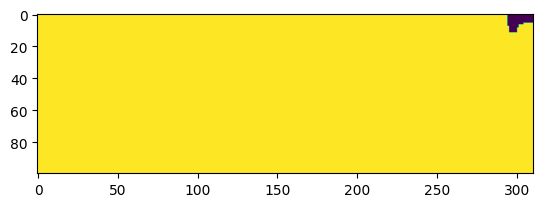

In [110]:
results = {}

# read video by index
video = cv.VideoCapture(videos[0])

ret = True
frame_number = -1
vehicles = [2,3,5]

# read the entire video
while ret:
    ret, frame = video.read()
    frame_number += 1
    if ret:
        results[frame_number] = {}
        
        # vehicle detector
        detections = coco_model.track(frame, persist=True)[0]
        for detection in detections.boxes.data.tolist():
            x1, y1, x2, y2, track_id, score, class_id = detection
            if int(class_id) in vehicles and score > 0.5:
                vehicle_bounding_boxes = []
                vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])
                for bbox in vehicle_bounding_boxes:
                    print(bbox)
                    roi = frame[int(y1):int(y2), int(x1):int(x2)]
                    
                    # license plate detector for region of interest
                    license_plates = np_model(roi)[0]
                    # process license plate
                    for license_plate in license_plates.boxes.data.tolist():
                        plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate
                        # crop plate from region of interest
                        plate = roi[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]
                        letter,image = get_letters(plate)
                        word = get_word(letter)
                        print(word)
                        # plt.imshow(image)
                        # if plate could be read write results
                        if letter is not None:
                            results[frame_number][track_id] = {
                                'car': {
                                    'bbox': [x1, y1, x2, y2],
                                    'bbox_score': score
                                },
                                'license_plate': {
                                    'bbox': [plate_x1, plate_y1, plate_x2, plate_y2],
                                    'bbox_score': plate_score,
                                    'number': word,
                                    'text_score': plate_score
                                }
                            }

write_csv(results, './outputs/resultsCNN.csv')
video.release()

If you liked this notebook, then do **Upvote** as it will keep me motivated in creating such kernels ahead. **Thanks!!**

In [106]:
results = pd.read_csv('./outputs/resultsCNN.csv')

# show results for tracking ID `1` - sort by OCR prediction confidence
results[results['track_id'] == 1.].sort_values(by='license_text_score', ascending=False)

,frame_number,track_id,car_bbox,car_bbox_score,license_plate_bbox,license_plate_bbox_score,license_plate_number,license_text_score


### STEP 6 Visualize the Results

In [101]:
def draw_border(img, top_left, bottom_right, color=(0, 255, 0), thickness=6, line_length_x=200, line_length_y=200):
    x1, y1 = top_left
    x2, y2 = bottom_right

    cv.line(img, (x1, y1), (x1, y1 + line_length_y), color, thickness)  #-- top-left
    cv.line(img, (x1, y1), (x1 + line_length_x, y1), color, thickness)

    cv.line(img, (x1, y2), (x1, y2 - line_length_y), color, thickness)  #-- bottom-left
    cv.line(img, (x1, y2), (x1 + line_length_x, y2), color, thickness)

    cv.line(img, (x2, y1), (x2 - line_length_x, y1), color, thickness)  #-- top-right
    cv.line(img, (x2, y1), (x2, y1 + line_length_y), color, thickness)

    cv.line(img, (x2, y2), (x2, y2 - line_length_y), color, thickness)  #-- bottom-right
    cv.line(img, (x2, y2), (x2 - line_length_x, y2), color, thickness)

    return img

In [102]:
# read video by index
video = cv.VideoCapture(videos[0])

# get video dims
frame_width = int(video.get(3))
frame_height = int(video.get(4))
size = (frame_width, frame_height)

# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('./outputs/processedCNN.mp4', fourcc, 20.0, size)

# reset video before you re-run cell below
frame_number = -1
video.set(cv.CAP_PROP_POS_FRAMES, 0)

True

In [103]:
ret = True

while ret:
    ret, frame = video.read()
    frame_number += 1
    if ret:
        df_ = results[results['frame_number'] == frame_number]
        for index in range(len(df_)):
            # draw car
            vhcl_x1, vhcl_y1, vhcl_x2, vhcl_y2 = ast.literal_eval(df_.iloc[index]['car_bbox'].replace('[ ', '[').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))
            
            draw_border(
                frame, (int(vhcl_x1), int(vhcl_y1)),
                (int(vhcl_x2), int(vhcl_y2)), (0, 255, 0),
                12, line_length_x=200, line_length_y=200)
            
            # draw license plate
            plate_x1, plate_y1, plate_x2, plate_y2 = ast.literal_eval(df_.iloc[index]['license_plate_bbox'].replace('[ ', '[').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

            # region of interest for license plate
            roi = frame[int(vhcl_y1):int(vhcl_y2), int(vhcl_x1):int(vhcl_x2)]
            cv.rectangle(roi, (int(plate_x1), int(plate_y1)), (int(plate_x2), int(plate_y2)), (0, 0, 255), 6)
            #endregion
            # write detected number
            (text_width, text_height), _ = cv.getTextSize(
                df_.iloc[index]['license_plate_number'],
                cv.FONT_HERSHEY_SIMPLEX,
                2,
                6)

            cv.putText(
                frame,
                df_.iloc[index]['license_plate_number'],
                (int((vhcl_x2 + vhcl_x1 - text_width)/2), int(vhcl_y1 - text_height)),
                cv.FONT_HERSHEY_SIMPLEX,
                2,
                (0, 255, 0),
                6
            )

        out.write(frame)
        frame = cv.resize(frame, (1280, 720))

out.release()
video.release()

In [104]:
import pandas as pd
import numpy as np

# Assuming your input data is stored in a CSV file named 'data.csv'
# You can adjust the file name or provide the data directly if it's not in a file
data = pd.read_csv('./outputs/resultsCNN.csv')

# Convert 'license_text_score' to numeric
data['license_text_score'] = pd.to_numeric(data['license_text_score'], errors='coerce')

# Calculate the total sum of license_text_score for each license_plate_number
total_license_score = data.groupby('license_plate_number')['license_text_score'].sum()

# Find the row with the maximum license_plate_score for each license_plate_number
max_license_score_row = data.loc[data.groupby('license_plate_number')['license_text_score'].idxmax()]

# Merge the two DataFrames on license_plate_number
result = pd.merge(max_license_score_row[['license_plate_number', 'track_id']], total_license_score.reset_index(),
                  on='license_plate_number', how='inner')

# Find the row with the maximum license_text_score for each track_id
max_license_score_row = result.loc[result.groupby('track_id')['license_text_score'].idxmax()]

# Display the result
print(max_license_score_row)


   license_plate_number  track_id  license_text_score
80                    W      32.0           33.356099
3                     B      40.0            9.900473
75                    R      45.0            2.262166
37                    G      48.0           31.677931
45                    H      51.0            0.404360
